# Working New Data generated by Data augmentation

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import random
from tqdm import tqdm
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array

In [3]:
train_damage_list = os.listdir('/content/drive/MyDrive/carscan/neww/train/damaged')
val_damage_list = os.listdir('/content/drive/MyDrive/carscan/neww/val/damaged')
train_not_damaged_list = os.listdir('/content/drive/MyDrive/carscan/neww/train/not_damaged')
val_not_damaged = os.listdir('/content/drive/MyDrive/carscan/neww/val/not_damaged')

In [4]:
def plot_bar(class_labels,counts,name):
    plt.figure(figsize = (10,10))
    f = sns.barplot(x = classes,y =counts)
    plt.xlabel("Class labels", fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.title("Number of Images in "+name+' folder', fontsize=20)
    plt.show()

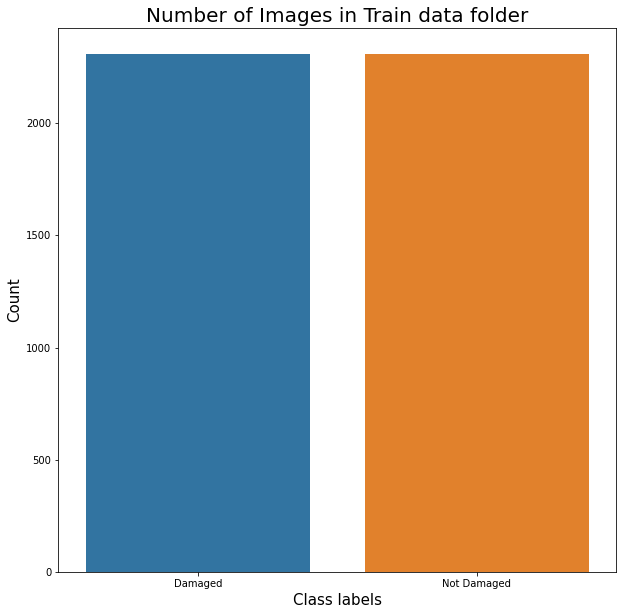

Number of Damaged images in train is 2309
Number of Not Damaged images in train is 2309


In [5]:
classes = ['Damaged','Not Damaged']
counts = [len(train_damage_list),len(train_not_damaged_list)]
plot_bar(classes,counts,'Train data')
for i in range(len(classes)):
    print('Number of '+classes[i]+' images in train is '+str(counts[i]))

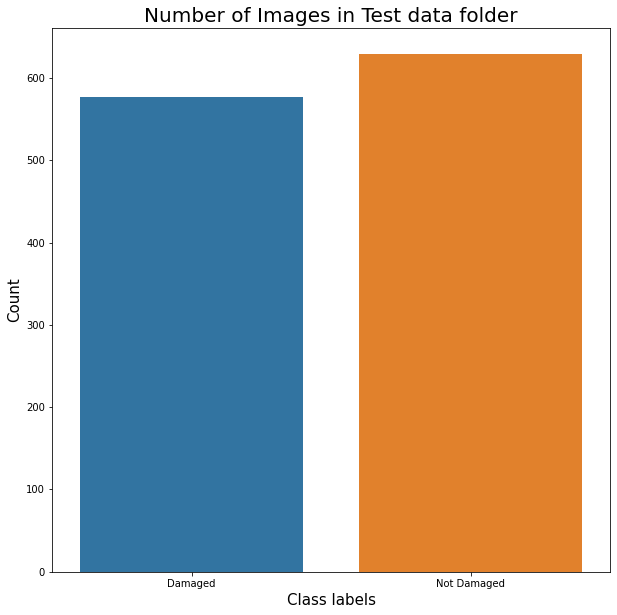

Number of Damaged images in test is 577
Number of Not Damaged images in test is 629


In [6]:
classes = ['Damaged','Not Damaged']
counts = [len(val_damage_list),len(val_not_damaged)]
plot_bar(classes,counts,'Test data')
for i in range(len(classes)):
    print('Number of '+classes[i]+' images in test is '+str(counts[i]))

In [7]:
from numpy.core.fromnumeric import shape
def img_shapes(files,path):
  shapes=[]
  for i in files:
    img = cv2.imread(path+'/'+i)
    shapes.append(img.shape)
  return shapes

## Sample file

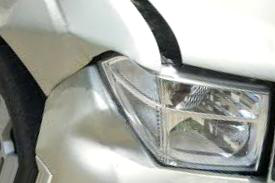

In [8]:
#Getting a sample file name from list of file names
sample_file = random.choice(train_damage_list)
sample_image1 = image.load_img('/content/drive/MyDrive/carscan/neww/train/damaged'+'/'+sample_file)
sample_image1

In [9]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

## Generating train_dataset & val_dataset

Target size of images = 150 x 150 pixels

Bnary classification

In [10]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory('/content/drive/MyDrive/carscan/neww/train',
                                          target_size=(150,150),
                                          batch_size = 32,
                                          class_mode = 'binary')
                                         
test_dataset = test.flow_from_directory('/content/drive/MyDrive/carscan/neww/val',
                                          target_size=(150,150),
                                          batch_size =32,
                                          class_mode = 'binary')
                                         

Found 4618 images belonging to 2 classes.
Found 1206 images belonging to 2 classes.


## Label encoding for the 2 classes

In [11]:
train_dataset.class_indices

{'damaged': 0, 'not_damaged': 1}

# CLASS WEIGHTS

*   Calculating weights by compute_class-weight function of sklearn
*   Converting the class_weights into dictionary





In [12]:
import json 
from sklearn.utils import compute_class_weight

train_classes = train_dataset.classes

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights
# output -> {0: 1.0, 1: 1.0}



{0: 1.0, 1: 1.0}

*   Next, converted the dictionary file into json file
*   Downloaded the class weigths json file directly from json



In [13]:
class_wt_dictionary = {
    0: 1.0,
    1: 1.0,
}

with open("sample.json", "w") as outfile:
    json.dump(class_wt_dictionary, outfile)

from google.colab import files
files.download('sample.json') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Training with CNN

In [13]:
model = keras.Sequential()

# Convolutional layer and maxpool layer 1
model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(512,activation='relu'))

# Output layer with single neuron which gives 0 for damaged or 1 for not_damaged
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1,activation='sigmoid'))

## Activating TensorBoard for activity logs & Evaluation Metrics

In [22]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


dataset  = 4618 images ( train directory)

Batch size = 32( by default), then each batch contains 32 images; total batches = 144.3125

Epochs = 50, then total weigth updates = 145*50 = 7250 times the weights get updated

steps_per_epoch = 4618/32 = 145 steps

In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = "/content/sample_data/checkpoints"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


baseline_model = model.fit(train_dataset,
         steps_per_epoch = 150,
         epochs = 20,
         class_weight = class_weights,
         validation_data = test_dataset,
         callbacks=[tensorboard_callback]
         
         )

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
er# are in place to discourage outdated usage, and can be ignored.

Epoch 1/20
150/150 [==============================] - 1571s 10s/step - loss: 0.5864 - accuracy: 0.6960 - val_loss: 0.5514 - val_accuracy: 0.7164


# Comments about type of accuracy calculated by above model:
From keras ref: When you pass the strings 'accuracy' or 'acc', we convert this to one of tf.keras.metrics.BinaryAccuracy, tf.keras.metrics.CategoricalAccuracy, tf.keras.metrics.SparseCategoricalAccuracy based on the loss function used and the model output shape. We do a similar conversion for the strings 'crossentropy' and 'ce' as well.

## Since, loss_function = binary_crossentropy, hence Binary Accuracy is calculated by Keras with threshold being set to 0.5 by default

Lint to binary accuracy: [link text](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryAccuracy)

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

# EVALUATION METRICS

##Obtaining accuracy, precison, recall, f1-score

In [66]:
y_pred = model.predict(test_dataset)

In [67]:
y_pred

array([[0.57268584],
       [0.94970834],
       [0.23329538],
       ...,
       [0.33311015],
       [0.11633039],
       [0.5386026 ]], dtype=float32)

In [79]:
y_pred1 = y_pred
y_pred1

array([[0.57268584],
       [0.94970834],
       [0.23329538],
       ...,
       [0.33311015],
       [0.11633039],
       [0.5386026 ]], dtype=float32)

In [81]:
len(y_pred1)

1206

In [83]:
for i in range(len(y_pred1)):
  if y_pred1[i]<0.5:
    y_pred[i]=0
  else:
    y_pred[i]=1

y_pred1

array([[1.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [90]:
import sklearn
from sklearn.metrics import confusion_matrix
result_mat = sklearn.metrics.confusion_matrix(test_dataset.labels, y_pred)
result_mat

array([[220, 357],
       [281, 348]])

In [94]:
tp = result_mat[0][0]
fp = result_mat[0][1]
fn = result_mat[1][0]
tn = result_mat[1][1]

precision1 = tp/(tp+fp)
recall1 = tp/(tp+fn)

f1_score = 2*precision1*recall1/(precision1+recall1)

print("precison = ",precision1)
print("recall = ",recall1)
print("f1-score = ",f1_score)

precison =  0.38128249566724437
recall =  0.43912175648702595
f1-score =  0.40816326530612246


In [56]:
test_dataset.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

## Prediction on a sample image

In [120]:

def predictImage(filename):
    img1 = image.load_img(filename,target_size=(150,150))
    
    plt.imshow(img1)
 
    Y = image.img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val < 0.5:
        
        plt.xlabel("damage",fontsize=30)
        
    
    elif val >= 0.5:
        
        plt.xlabel("not_damage",fontsize=30)

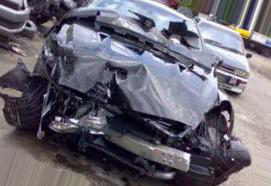

In [116]:
#Getting a sample file name from list of file names
sample_file = random.choice(val_damage_list)

sample_img1 = image.load_img('/content/drive/MyDrive/carscan/neww/val/damaged'+'/'+sample_file)
sample_img1

[[1.]]


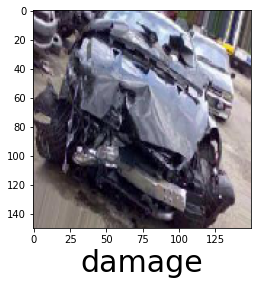

In [119]:
predictImage('/content/drive/MyDrive/carscan/neww/val/damaged'+'/'+sample_file)